# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [3]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())

    # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 17, alternate_sign=False)
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")
    toxic_data['excl_count'] = toxic_data['comment_text'].str.count("!")

    X_quant_features = toxic_data[["word_count", "punc_count", "excl_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [4]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/toxiccomments_train.csv', my_random_seed=500)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [5]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 12999, 'Neg': 114657, 'TP': 6558, 'TN': 58750, 'FP': 55907, 'FN': 6441, 'Accuracy': 0.5115936579557561, 'Precision': 0.10498679260385817, 'Recall': 0.5045003461804755, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [6]:
from sklearn import linear_model
svm = linear_model.SGDClassifier()
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12999, 'Neg': 114657, 'TP': 12878, 'TN': 114548, 'FP': 109, 'FN': 121, 'Accuracy': 0.9981982828852541, 'Precision': 0.9916069916069916, 'Recall': 0.990691591660897, 'desc': 'svm_train'}


### MODEL: logistic regression

In [7]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12999, 'Neg': 114657, 'TP': 12950, 'TN': 114598, 'FP': 59, 'FN': 49, 'Accuracy': 0.9991539763113367, 'Precision': 0.9954646782996387, 'Recall': 0.996230479267636, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [8]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 12999, 'Neg': 114657, 'TP': 12729, 'TN': 103216, 'FP': 11441, 'FN': 270, 'Accuracy': 0.9082612646487435, 'Precision': 0.5266446007447249, 'Recall': 0.9792291714747289, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [9]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron')
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 12999, 'Neg': 114657, 'TP': 12897, 'TN': 114596, 'FP': 61, 'FN': 102, 'Accuracy': 0.9987231309143323, 'Precision': 0.9952924834079333, 'Recall': 0.9921532425571198, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [10]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(normalize=True)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 12999, 'Neg': 114657, 'TP': 12960, 'TN': 100227, 'FP': 14430, 'FN': 39, 'Accuracy': 0.8866563263771385, 'Precision': 0.47316538882803943, 'Recall': 0.9969997692130164, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=2, random_state=0)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/yujunjiang/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 12999, 'Neg': 114657, 'TP': 0, 'TN': 114657, 'FP': 0, 'FN': 12999, 'Accuracy': 0.8981716488061666, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_train'}


/Users/yujunjiang/Desktop/Machine Learning/final_assignment_1_optional_iteration_1/my_measures.py:25: RuntimeWarning: invalid value encountered in long_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


### ROC plot to compare performance of various models and fits

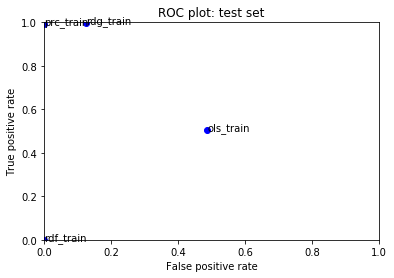

In [12]:
fits = [ols_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

### let's look at some false positives:

In [13]:
rdg_predictions = rdg.predict(X_train)

In [14]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
17
"40, 25 January 2008 (UTC)

NO, i am NOT being uncivil. Try UUser:Lbrun12415. he's called other users a waste of sperm, a moron, etc. Block him, the one who's truly uncivil. -  

Rikara, I recommend you cool it. Yelling and arguing is not going to get you anything. Take a breather and come back when you're feeling calmer. Otherwise you will find your talk page protected and you will be forced to take a breather. -  
I have seen nothing of the sort from that user (who has since been renamed), at the very least not in this current situation. -'''' (Blah v^_^v) 23:"
* * * * * * * * * 
31
Oh, and you don't have any photos of the band which you took yourself do you? If so, we could use them over at the Wikimedia Commons. -'''' (Talk)
* * * * * * * * * 
56
Do you know where I put my brain?
* * * * * * * * * 
77
removed....and why?  all because you simply do not like him
* * * * * * * * * 
89
come here on the basis of
* * * * * * * * * 
110
What's up with this 

7256
Editing Wikipedia is a collaborative effort amongst editors willing to work in an atmosphere of camaraderie and mutual respect.  If anyone thinks that their edits are more important than other editors', then they are are mistaken.  Please take the time to understand the concerns of others who have just as much right to edit this article as you do.
* * * * * * * * * 
7319
Theres nothing rude or uncivilized about my above comment. You reverted my edit plain and simple. I know your new to wikipedia and im trying to help you but do not undo edits ex if you dont know what you are doing. If you feel so strongly about it take it to the talk page otherwise let it die. Also note saying people are rude and uncivilized, if you say it to the right person, will get you blocked. Im sorry if I come off mean but you shouldnt just undo peoples edits ex when you are in the wrong/dont know what you are doing which is obviously the case here.
* * * * * * * * * 
7408
CJ DUB Continues To Insult Wiki Ed

12730
Okedem if your really that bothered about the anon's comments, you could consider 1. Ignoring them 2. asking someone else to deal with them 3. Not insulting the anon in a way which is libel to start a fight.
* * * * * * * * * 
12846
Hmm... vandalist brings up what I thought to be a tired point. But I got to tell you. That such an inane article can be so lengthy makes me wonder what the hell I am contributing to.
* * * * * * * * * 
13363
Do you like men? You seem to sound as if you like men.
* * * * * * * * * 
13599
Im sorry 

I did copy it from a website, i guess ill delete it.
* * * * * * * * * 
13755
I guess not, since it is stated by neutral historians, rather than leftist politicians. Random qoutes by left-wing politicians are of course appropriate, instead of those stupid historians.
* * * * * * * * * 
13967
AQuestion forU 

What is a mid-life crisis? 86.179.40.116
* * * * * * * * * 
14290
because vain they do not start to burn thread
* * * * * * * * * 
14367
Actually, most 

19659
The fact that Afghanistan was called Aryana for millennia, and the native people have always called themeselves Arianis never crossed anybody's mind as odd. Afghanistan is in Central Asia, next to India (if you study the history of India, it's nothing but one Afghan invasion after another, from old Aryans, to Kushans, Hephtalites, up to the Mughals who came from Afghanistan, even if Babur was Turk).
* * * * * * * * * 
19680
I'm thinking about deleting War on Terror, Operation Enduring Freedom - Horn of Africa, and Operation Enduring Freedom - Phillipines because they are redundant. I'd like for people vote on it.
* * * * * * * * * 
19694
":::Sure, if you will apologise for leaving in what amounts to an accusation against a helpless tortured youth that he ""confessed"" being described in a manner that appears to side with the IRA murderers who did the torturing. Fine.  

"
* * * * * * * * * 
20043
"
 User talk:Tbeatty/Archive08    
-    
- BmS wrote    
- You are too funny! I am G

25024
No 

You are ma babe so get it right. I am in love with yoooooou. Forever. Like the apple of eternity.
* * * * * * * * * 
25364
Which admins? EA Admins or Wikipedia Admins?
* * * * * * * * * 
25508
"
 If you had any sense at all, you would be better off laughing at yourself! Anyone who has read the Talk:Konkani_Brahmins would probably think that you are a fool, if they hadn't already read your edit summaries.  Holla at me!  "
* * * * * * * * * 
25686
"
""In the case of sons of a duke or marquess, who by courtesy have ""Lord"" prefixed to their given and family name, the wife is known by the husband's given and family name with ""Lady"" prefixed, e.g. The Lady John Smith; the daughters of dukes, marquesses and earls are by courtesy Ladies; here that title is prefixed to the given and family name of the lady, e.g. The Lady Jane Smith, and this is preserved if the lady marries a commoner, e.g. Mr John and The Lady Jane Smith. The predicate 'The' should be used prior to ""Lady"" or "

33674
"
I don't get it. What ""retraction of his claims"" are you referring to?   "
* * * * * * * * * 
33863
"

 Hello from a main page regular 

Recent vandal attacks on the main page where an 'interesting' picture has been snuck in via unprotected subparts of the main page have been annoying at the least - Yes it's true. It has been one or two lapses of concentration by admins who forgot to protect something that they placed on the front page templates. Admins are human, they do make mistakes. Everyone has been poked and reminded. I'm not saying that it won't happen again, but everything that should be done has.

However.

What should happen when such a vandal attacks?
Within minutes someone with admin ability spots it, quietly reverts it and covers the cracks that the vandal oozed in via. The vandal is blocked, defeated and deflated, they move on.

What does happen when such a vandal attacks?
Everyone, their dog, cat, hamster and rabbits swamp this talk page with ""OMG!11!! I'M OFFE

39583
First off, what the other's have said. Socks got plenty of media coverage while in the White House, kids who die young and DON'T have media coverage just need a stub on their parents' page(s). Also, plenty of stubs get DYK'ed.
* * * * * * * * * 
39717
Please don't tell people the truth about me anymore.
* * * * * * * * * 
39888
"

""Case swapping"" does exist.  I know, first hand, ""at least"" ten kids who have done so themselves.  I do, however understand that Wikipedia is not an instruction manual.  Therefore, I will re-post the ""Case-Swapping"" section and leave out the instructions on how to do so.  I hope you respect my descion to spread this knowledge and not remove my contribution again. Thank You"
* * * * * * * * * 
40057
"

 August 2007 
 Please stop. If you continue to ignore our policies by introducing inappropriate pages, such as Panzer pursuit, to Wikipedia, you will be blocked.   • (Deeds•Talk) "
* * * * * * * * * 
40091
I'm not like you, I respect everyone's opini

45808
change my bttf2 thing though
* * * * * * * * * 
45962
BillCJ. Do not patronise me. What I have said is 'verifiable'. Go to the list of Jamaican Prime Ministers. How many of them are 'dark-skinned' by Jamaican standards? Only one. That is the verification. It is you who are biased. You are removing this paragraph not because it is not 'verifiable', but because you personally don't like what is being said as a result of your own subjective bias. I only have to look at your page to see where your bias lies - it is as plain as a picture - and a picture is worth a thousand words. You are applying a double-standard. If you were being sincere you would systematically go through the entire article removing every sentence that was not 'verified'. How dare you interfere in a subject of which you have literally no knowledge. As I said, go to the list of Jamaican Prime Ministers. How many of them are 'dark-skinned'?
* * * * * * * * * 
46074
"
Ha! ) Well, I'm off to bed, so cya. Cheers, '''''

52369
"Welcome. I think this might officially make you ""white & nerdy."" )  (talk • contribs) "
* * * * * * * * * 
52728
Tell your friend not to call me a tosser. Oh, and by the way, it's she, not he. 81.155.156.42
* * * * * * * * * 
52763
It's quite a funny coincidence that all of the IP editors attacking the 50% page are from the UK and several of them have also significantly vandalizes Sandpit, including Special:Contributions/83.67.56.138.  Not funny ha-ha, mind you, but funny. -
* * * * * * * * * 
52890
We should go with the english common usage, for those article titles.
* * * * * * * * * 
53292
Nominated your horrible article for deletion. 

Sorry.
* * * * * * * * * 
53343
Am I not free to call a duck a duck? 64.230.84.232
* * * * * * * * * 
53483
o.k. talk to u tomorrow!!!!!!!!why the heck did he do that
* * * * * * * * * 
53641
"  WAR ? battle  ? ==

This was not a battle.
Russia had won before hand.
THis was a murder commited by georgia just to spite the pro-russian ""rebels"

57911
"== A barnstar for you! ==

  The Real Life Barnstar This Wiki Is About My Self, And This Is Real.   "
* * * * * * * * * 
58297
efforts for the gay community keep it up man.
* * * * * * * * * 
58338
|No legitimate reason for said block, I don't believe that I was wrong here. And furthermore, I've been harassed by two users who are the reasons behind the mod who blocked me. Most importantly, thanks to one of said users I had to have my talk page protected because his harassment of me led to  harassing me through ridiculous IP sock edits. I believe said user is also wikistalking me.
* * * * * * * * * 
58452
"

 Hi Honey! Miss Me? 

We the ""Anti-Censorship Committee"" in conjunction with the ""Protest Wikipedia Censorship"" Facebook page feel it is our duty to formally relay to you that we have no desire to participate any further in these games you play with people's rights. You were given a run for your money yesterday and that was epic as well as amusing on our end hee hee:-) An

64469
DestructoBot kills all images regardless of their tags!
* * * * * * * * * 
64491
aaa 

im undead dont plaey with me and and and .......???!!1
* * * * * * * * * 
64700
Hi and thanks for your comments, fact is though that if personal attacks are going to get people blocked then he should have seen one a long long time ago. I don't care too much for personal attacks really so don't worry I'm not gonna go on any personal attack spree or anything of the sort. He isn't an admin though fyi and if an admin truly were to block me for using that one word then that would just be the most hypocritical thing ever. Take care.
* * * * * * * * * 
64783
Your vandalism of Keith Briffa 

Dear Dr Schulz, could you please immediately stop vandalizing the article about Keith Briffa? Thank you very much. Are you a sockpuppet of William Connolley?
* * * * * * * * * 
64962
Disputed non-free use rationale for Image:Hayato Kobayashi UC0087.jpg
Thank you for uploading Image:Hayato Kobayashi UC0087.jpg. Howe

70385
nobody cares brittanica, here is wikipedia, here is not depends on ONE source, an stop editing those pages
* * * * * * * * * 
70425
"
You live in Vegas?  (Hit  "
* * * * * * * * * 
70442
"

 Block me! 

You can block me whenever you want.
When the block will expire I will post my proof again.
Forever.
If you block me forever, I will ask somebody also to post my proof for me.
Forever.

I think it's not fair what you did on ""square pyramidal number page"".
Do you think it's fair to make a content remove only because you decided that
it's not interesting?
A civilized person would discuss it in the discussion page.
I'm not dropping this."
* * * * * * * * * 
70566
White Stolen Generations
There is a section on the (Indigenous) Stolen Generation, but shoudn't also the White Stolen Generation be recognized here as well? White Stolen Generations
* * * * * * * * * 
70784
UT

i know that jar cure did not do it ..nuff luv tru fan
* * * * * * * * * 
70808
I did not know you are a lord. I am

81118
Associação Académica de Coimbra 2
One user did it all wrong after has read your requests and surveys. It's a shame that someone is trying to ruin the work of others just to promote his own stupid, ignorant or biased view about one topic. I know you didn't agree with his actions. I know it isn't your fault but it really pissed me off. I hope someone would be able to revert all the mess he did.
* * * * * * * * * 
81199
those are serious accusations that you are making, the ip's dont match and you are suggesting that I am a troll, thats a personal attack, I am reporting you!
* * * * * * * * * 
81350
"

 A barnstar for you! 

  The Anti-Vandalism Barnstar For Protecting PS Barito Putera and Pro Duta FC Article despite you are Blocking me from Contributing to WikiPedia for 72 Hours    "
* * * * * * * * * 
81419
Probably the Player's Handbook, although I don't have it handy at the moment. 75.149.195.214
* * * * * * * * * 
81592
Skilled group 

A-holes of the labour market
* * * * * * *

89126
Hates Status Quo - Loves Hawkwind
* * * * * * * * * 
89202
do it again and you're reported
* * * * * * * * * 
89346
"

did you just call me ""stupid"". I cannot believe this. You block people for personal attacks and then you just come at them.  THis is totally relevant.   JohnHistory"
* * * * * * * * * 
89662
You seemed like you were going to be civil until you started accusing me of doing something off-topic, like taking CT out of New England or trying to prove that CT was not New England.  I was only proving that Boston is no business or cultural hub for CT.  I did that and you did not like it.  Those are the facts.
* * * * * * * * * 
89711
"

 Sabbath Bloody Sabbath 

""Wrongly placed warning"" Not a single apology for that?   "
* * * * * * * * * 
89756
After looking at your userpage you also seem to have articles related to islam in your sites, just as Bless Sins does, and as your pathetically disguised bais shows, you are being nothing more than a simple hypocrit to attack 

94198
You just can't help yourself, can you? 

Could you find some other hobbies?  You just make yourself look bad when you mindlessly revert.
* * * * * * * * * 
94395
Perhaps this should be merged with an article on Half-Life 2 mods?
The world of modding Half-Life 2 and the Source engine is rather large, and an encyclopedic article on the topic would be useful. Then this list could simply be merged with that article.
* * * * * * * * * 
94616
instead of protection of property
* * * * * * * * * 
94630
"

 Yamla 

Aright well let me ask you a question then. If I had said leave me alone would have that been taken as an attack? And as you already read the first attack was out of unawareness of EVERY wikipedia policy, honestly do you know how long it would take to read them all! And ignorance, think about that word for a minute. Is calling a user ignorant when they post a comment like this, ""Even though mediterranean people are commonly Latino anyway"", a personal attack? I don't know why 

100454
":::::It can and should be restored. Oh and let me quote yourself here: ""Please note that this is a discussion and you don't have any right or authority to demand that it ends.""    

"
* * * * * * * * * 
100596
GIVE ME LIBERTY OR GIVE ME DEATH!    
'LIVE FREE OR DIE TRYING!'
* * * * * * * * * 
101940
This is not a personal attack. This is a civil attempt to request that you stop vandalizing this page. The fact that my edit does not mesh with your political views does not make it vandalism. Please stop. You're hurting my feelings and making me cry like a reclusive depressive. - Lewis Ranja
* * * * * * * * * 
101978
"
...yeah, I did make a balls up of it. Sorry about that. Back to school for me... inspect damage⁄berate "
* * * * * * * * * 
102073
OK I added a bunch of redirects.
* * * * * * * * * 
102330
I just wanted to know!! 

I just wanted to know if you're Rudget! Are you, or arent you?

Also, I was just about to apologize when I got the message.orz I am truly very sorry. I

112995
), trauma (when it involves the midbrain
* * * * * * * * * 
113264
This is true  Bush liberating 35 million Iraqis and Afghanis is just like Hitler oppressing millions of Europeans.  Oh, wait, wasn't it an American President who liberated Western Europe?  And Eastern Europe, later on?
* * * * * * * * * 
113285
Ding-dong the witch is dead 

Which old witch? The wicked witch 

Ding-dong the wicked witch is dead 

Wake up you sleepyhead 

Rub your eyes, get out of bed 

Wake up the wicked witch is dead 

She's gone where the goblins go 

Below - below - below 

Yo-ho, let's open up and sing and ring the bells out 

Ding Dong' the merry-oh, sing it high, sing it low 

Let them know the Wicked Witch is dead
* * * * * * * * * 
113388
Additionally, I disagree that sources should mention Zheng He- it is utterly irrelevent if Zheng he's name is mentioned- the argument is based on timelines and thus still attacks the fallacious claims.  Furthermore, it proves the poor quality original pro

119188
More red herrings and straw men distractions from Danny. You are now playing the wounded martyr in the vain hope you will pull in the gullible into feeling sorry for you enough to forget all the flawed accusations you have been putting out over the weeks about Raymond Franz. Danny, go and read the books then you may comment on their content, and only then. Central Posted 20 July 2005
* * * * * * * * * 
119431
What makes you think that I care about anything you have to say about ducks or expressos or socks or anything else? Leave me alone. 193.109.199.35
* * * * * * * * * 
119607
understand anything you people say to me.
* * * * * * * * * 
119818
, which is obviously my fault
* * * * * * * * * 
119958
"

Vivokid
Hi there, Vivokid, welcome to Wikipedia.  As you've noticed, I've moved your new page to your userpage.  Please stop writing encyclopedia pages about yourself.  You are welcome to write about yourself on your userpage.  If you need help in starting up a Wikipedia account 

125757
I thought you were busy with real life...
* * * * * * * * * 
125894
-Why dont you boldt the wheels to your wrists and ankes and be a go-go-go-Kart?
* * * * * * * * * 
125975
sound right coming out of your mouth
* * * * * * * * * 
126151
and this must be illegal
* * * * * * * * * 
126160
Bad Redirect 
Please remove the redirect from the X-24C page, that aircraft was distinctly different in design, builder, mission, etc, and restore that aircrafts unique content to its page.75.67.80.68
* * * * * * * * * 
126268
Every documentary is without error? Interesting. ~
* * * * * * * * * 
126684
"

Language and Mind-set of a Popular 1950s Musical

I have removed the ""Language and Mindset..."" section of the article. The whole section is *very* subjective, depending entirely on your point of view, and  could be applied to plenty of films from that era. Further, none of the information there was cited. I am posting the section here in its entirety for reference.   

Language and Mind-set of

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [15]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3226, 'Neg': 28689, 'TP': 1611, 'TN': 14787, 'FP': 13902, 'FN': 1615, 'Accuracy': 0.5138022873257089, 'Precision': 0.10384838522529491, 'Recall': 0.49938003719776813, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [16]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3226, 'Neg': 28689, 'TP': 2102, 'TN': 27200, 'FP': 1489, 'FN': 1124, 'Accuracy': 0.9181262729124237, 'Precision': 0.5853522695627958, 'Recall': 0.6515809051456912, 'desc': 'svm_test'}


### MODEL: logistic regression

In [17]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3226, 'Neg': 28689, 'TP': 2042, 'TN': 27173, 'FP': 1516, 'FN': 1184, 'Accuracy': 0.91540028199906, 'Precision': 0.5739179314221473, 'Recall': 0.6329820210787352, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [18]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3226, 'Neg': 28689, 'TP': 2082, 'TN': 23668, 'FP': 5021, 'FN': 1144, 'Accuracy': 0.8068306438978536, 'Precision': 0.2931155849640997, 'Recall': 0.6453812771233726, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [19]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3226, 'Neg': 28689, 'TP': 2047, 'TN': 27243, 'FP': 1446, 'FN': 1179, 'Accuracy': 0.9177502741657528, 'Precision': 0.5860292012596622, 'Recall': 0.6345319280843149, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [20]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3226, 'Neg': 28689, 'TP': 3086, 'TN': 22752, 'FP': 5937, 'FN': 140, 'Accuracy': 0.8095879680401066, 'Precision': 0.34201485093649564, 'Recall': 0.9566026038437694, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [21]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3226, 'Neg': 28689, 'TP': 0, 'TN': 28689, 'FP': 0, 'FN': 3226, 'Accuracy': 0.8989190036033213, 'Precision': nan, 'Recall': 0.0, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

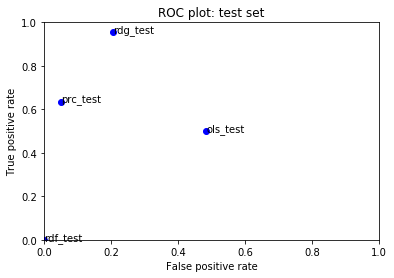

In [22]:
fits = [ols_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='data/toxiccomments_test.csv', my_random_seed=500, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 131072)
Look at a few rows of the new quantitative features: 
   word_count  punc_count  excl_count
0          72          10           0
1          13           1           0
2          16           0           0
3          38           3           0
4           7           1           0


---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [24]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.41536522942728055


In [25]:
raw_data.head()

,id,comment_text,word_count,punc_count,excl_count
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,72,10,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,13,1,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",16,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",38,3,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,7,1,0


In [26]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,False
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [27]:
my_submission.shape

(153164, 2)

In [28]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation